<a href="https://colab.research.google.com/github/felipemaiapolo/datagirls_clustering_2020/blob/main/Workshop_DataGirls2020_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop Data Girls 2020: Clustering 


**Autor:** Felipe Maia Polo - Co-fundador e ex-presidente do Neuron - *Data science and Artificial Intelligence*, economista pela USP e mestrando em Estatística pela mesma instituição. Apaixonado por matemática, estatística e *data science*.

**Contato:** felipemaiapolo@gmail.com - https://www.linkedin.com/in/felipemaiapolo/

**Feedback:** https://forms.gle/U6yBVSYwxNRWaE15A

**Sugestões de leitura**

1. **Probabilidade:** Ross, S. (2014). A first course in probability. Pearson.
2. **Probabilidade e Estatística:** Morettin, P. A., & BUSSAB, W. O. (2017). Estatística básica. Editora Saraiva.
3. **Análise de Regressão (linear & logística):** Wooldridge, J. M. (2015). Introductory econometrics: A modern approach. Nelson Education.
4. **Machine Learning:** James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer.

## Como segmentar clientes em grupos mais ou menos uniformes de forma a ter um melhor direcionamento de políticas?


Vamos começar chamando os pacotes que utilizaremos:

In [ ]:
import pandas as pd
import numpy as np
import requests
import io

from sklearn.datasets.samples_generator import make_blobs
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans 
from sklearn.metrics import  silhouette_score, silhouette_samples

from IPython.display import Image
from IPython.core.display import HTML 

import matplotlib.pyplot as plt 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Hoje vamos focar nossas atenções na técnica *K-Means*, um modelo muito importante e que é capaz de descobrir estruturas escondidas nos dados. Essa técnica é um modelo de clusterização, ou segmentação, e é utilizada para agruparmos indivíduos diferentes em nossa base de dados. Mas por que isso é importante? No exemplo a seguir, por exemplo, é importante pois poderemos entender melhor nossos clientes e nos direcionar mais objetivamente a cada um dos grupos. 

Antes de começarmos, um comparação entre tarefas de classificação e de clusterização:

In [ ]:
#Imagem retirada de https://mc.ai/supervised-vs-unsupervised-learning/
Image(url= "https://raw.githubusercontent.com/felipemaiapolo/datagirls_clustering_2020/main/unsup.jpg", width=900, height=500)

A partir de agora vamos trabalhar com uma base de dados de clientes de um shopping. Essa base de dados foi retirada do Kaggle (https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python), conta com 200 clientes, sendo que temos 4 características de cada um deles dada pelas variáveis:

1. **CustomerID**: ID único de cada cliente
2. **Gender**: Gênero (Feminino ou Masculino)
3. **Age**: Idade do cliente
4. **Annual Income**: Renda anual do cliente (em mil dólares)
5. **Spending Score (1-100)**: Pontuação criada pelo shopping com base nos comportamentos de consumo


Abrindo a base de dados:

In [ ]:
download = requests.get("https://raw.githubusercontent.com/felipemaiapolo/datagirls_clustering_2020/main/shoppingdata.csv").content
data = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',')

Checando o formato da base de dados:

In [ ]:
data.shape

(200, 5)

Checando os dados com *.head()*:

In [ ]:
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Para facilitar a manipulação da nossa base de dados, vamos transformar a variável Gênero em binária, sendo que o gênero feminino será representado por 1 e o masculino por 0:

In [ ]:
def genero(x):
    if x == 'Female':
        return 1
    else:
        return 0
    
data['Genre'] = data['Genre'].apply(genero)
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


O modelo de agrupamento (K-Means) que utilizaremos funciona bem somente com variáveis quantitativas, então não utilizaremos a variável de gênero para realizar o agrupamento. Como não utilizaremos nem a variável de gênero e nem a variável de Id no momento do agrupamento, vamos criar uma base de dados auxiliar somente com as variáveis que queremos. Preste atenção que este momento é **muito** importante, pois devemos verificar se alguma das variáveis que utilizaremos tem valores faltantes e, se tiverem, deveremos manter somente aqueles indivíduos que não têm valores faltantes em nenhuma das variáveis. Vamos checar com a função *describe()*:

In [ ]:
data.describe()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,0.560000,38.850000,60.560000,50.200000
std,57.879185,0.497633,13.969007,26.264721,25.823522
min,1.000000,0.000000,18.000000,15.000000,1.000000
25%,50.750000,0.000000,28.750000,41.500000,34.750000
50%,100.500000,1.000000,36.000000,61.500000,50.000000
75%,150.250000,1.000000,49.000000,78.000000,73.000000
max,200.000000,1.000000,70.000000,137.000000,99.000000


É possível ver que todas as variáveis têm "count" igual a 200, que é o número de linhas na base, então não temos valores faltantes, dado que o dataset está bem formatado e poderíamos fazer a identificação deste maneira. Criando nossa base auxiliar somente com as variáveis de interesse:

In [ ]:
temp=data.copy(deep=True)

temp.drop(["CustomerID"], axis=1, inplace= True)
temp.drop(["Genre"], axis=1, inplace= True)

Antes de realizar o agrupamente, faremos uma normalização nos dados, pois dados com escalas diferentes podem influenciar/viesar nossos resultados. Para isso, utilizaremos a normalização entre 0 e 1 (maior valor assume 1 enquanto o menor valor assume 0):

In [ ]:
scaler = MinMaxScaler()
temp = scaler.fit_transform(temp) 

Perceba que aqui não fizemos uma divisão entre base de treino e teste, pois não é muito comum agir dessa maneira quando nosso fim é o agrupamento, mesmo que existam algumas abordagens em que isso possa ser feito. Uma maneira de sabermos mais ou menos como nossos dados podem se agrupar é utilizando a técnica TSNE, que é uma técnica de redução de dimensionalidade. Diferentemente do PCA, esta técnica foi criada com o intuito de se manter a estrutura de distâncias presentes nos dados originais. Sendo assim, ela consegue manter muito bem a estrutura de agrupamento entre os indivíduos. Vamos utilizar esta técnica somente para tentar visualizar, em duas dimensões, como nosso modelo *K-Means* provavelmente fará as divisões de clusters:

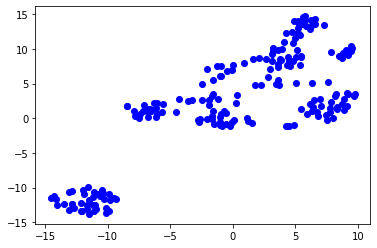

In [ ]:
tsne = TSNE(n_components=2, random_state=42).fit_transform(temp)

plt.plot(tsne[:,0],tsne[:,1], 'bo')
plt.show()

Na figura acima é possível ver que há algumas maneiras de se agrupar os indivíduos, sendo elas mais ou menos claras. 

Agora vamos passar da etapa mais visual de identificação para a parte algoritmica, que é quando vamos identificar clusters nos nossos dados com o auxílio do modelo K-Means. Como todo modelo de Machine Learning, o K-Means tenta minimizar alguma função de erro dado o número de clusters $K$ escolhido pelo cientista de dados, ou seja, $K$ é um hiperparâmetro. A função de erro em questão se chama WCSS (Within Cluster Sum of Squares) e ela nos dá uma a soma dos erros quadráticos cometidos por cada indivíduo de cada um dos clusters. 

Para ficar mais claro, vamos de exemplo. Suponha que em nossos dados tenhamos dois clusters, como na figura abaixo:

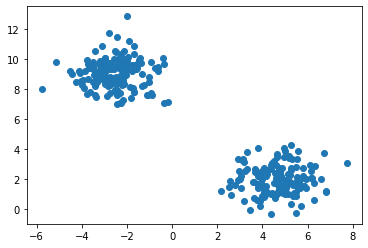

In [ ]:
X, y = make_blobs(n_samples=300, centers=2, n_features=2, random_state=42)

plt.scatter(X[:,0],X[:,1])
plt.show()

É visível a divisão que pode ser feita, vamos fazê-la então:

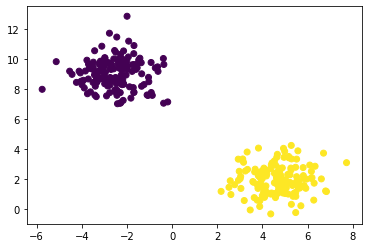

In [ ]:
plt.scatter(X[:,0],X[:,1], c = y)
plt.show()

O primeiro passo para computar o erro WCSS é achar o centro (centróide) de cada um dos clusters. Vamos chamar o cluster da esqueda de cluster 0 e o cluster de direita de cluster 1 e agora vamos calcular seus centros (centróides), que são dados pelas médias de todos os pontos que fazem parte daquele cluster:

In [ ]:
c0=np.mean(X[y==0], axis=0)
c1=np.mean(X[y==1], axis=0)

c0, c1

(array([-2.55143224,  9.02835242]), array([4.66375945, 1.92025297]))

Para calcular o erro WCSS basta calcular a distância euclidiana ao quadrado entre todos os pontos e o seu repectivo centróide e somar tudo. A distância euclidiana, e o seu quadrado, entre um ponto $x=(x_1,x_2)$ e outro ponto $y=(y_1,y_2)$ são dadas pelas seguintes fórmulas:

\begin{equation}
d(x,y)=\sqrt{(x_1-y_1)^2+(x_2-y_2)^2} \Rightarrow d^2(x,y)=(x_1-y_1)^2+(x_2-y_2)^2
\end{equation}

Vamos calcular o erro WCSS para esse nosso exemplo:


In [ ]:
WCSS0=np.sum((X[y==0]-c0)**2)
WCSS1=np.sum((X[y==1]-c1)**2)

WCSS=WCSS0+WCSS1

print("O erro WCSS cometido pela clusterização do exemplo é", WCSS)

O erro WCSS cometido pela clusterização do exemplo é 566.4678820515289


Perceba que na conta acima, calculei o erro WCSS para cada cluster separadamente e depois somei tudo. Essa configuração de cluster que criamos é a que minimiza o erro WCSS dada a quantidade de 2 clusters. Vamos fazer algumas mudanças em $y$ para você ver uma configuração de cluster que não é boa - vamos forçar os 50 primeiros indivíduos a serem do cluster 0 e os 50 últimos a serem do cluster 1:

In [ ]:
y[:50]=0
y[250:]=1

Vamos plotar novamente os clusters:

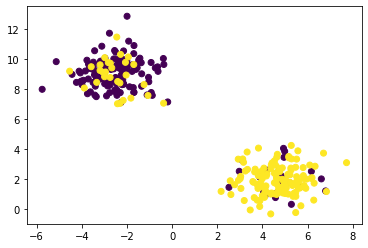

In [ ]:
plt.scatter(X[:,0],X[:,1], c = y)
plt.show()

Parece que a divisão feita agora não foi muito inteligente. Vamos verificar isso pelo erro WCSS:

In [ ]:
c0=np.mean(X[y==0], axis=0)
c1=np.mean(X[y==1], axis=0)

WCSS0=np.sum((X[y==0]-c0)**2)
WCSS1=np.sum((X[y==1]-c1)**2)

WCSS=WCSS0+WCSS1

print("O erro WSCC cometido pela clusterização do exemplo é", WCSS)

O erro WSCC cometido pela clusterização do exemplo é 5001.656163458907


É possível ver que se a divisão não for bem feita, e erro tende a ser muito alto. Para a aplicação do modelo K-Means, basta dizer quantos clusters você quer encontrar nos dados e ele fará uma divisão de forma a minimizar o erro WCSS (nem sempre ele chega na melhor divisão possível, mas quase sempre chega a um resultado satisfatório). No exemplo acima já começamos com o vetor $y$ que indicava a que cluster pertencia o indivíduo, mas na vida real, começaremos somente com $X$ e o modelo K-Means nos retornará $y$. A clusterização pega dados sem rótulos e rotula cada um de seus indivíduos da seguinte maneira:

In [ ]:
Image(url= "https://raw.githubusercontent.com/felipemaiapolo/datagirls_clustering_2020/main/p7.png", width=700, height=300)

Adaptado de: https://cdn-images-1.medium.com/max/1600/1*tWaaZX75oumVwBMcKN-eHA.png

Agora vamos aplicar o modelo K-Means para achar exatamente 3 clusters em nossos dados (só para teste):

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state=42)
kmeans.fit(temp)

cluster_labels = kmeans.predict(temp) #Pegando os rótulos

Agora que já dividimos nossa base em dois clusters, vamos fazer a visualização com as variáveis geradas pelo TSNE:

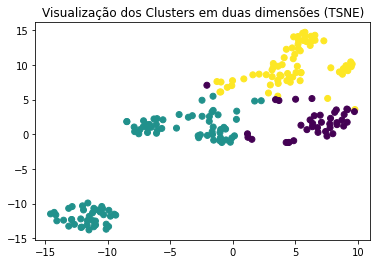

In [ ]:
plt.scatter(tsne[:,0], tsne[:,1], c = kmeans.labels_)
plt.title('Visualização dos Clusters em duas dimensões (TSNE)')

plt.show()

Com três clusters conseguimos um resultado razoável. Mas como fazer a otimização do número de clusters!? Existe a medida de se chama Silhueta Média (https://en.wikipedia.org/wiki/Silhouette_(clustering)). Essa medida varia de -1 a 1 e quanto mais próximo de 1, mais coesos serão os clusters formados. Vamos rodar o K-Means para vários números de clusters e descobrir qual aquele com a melhor Silhueta Média:

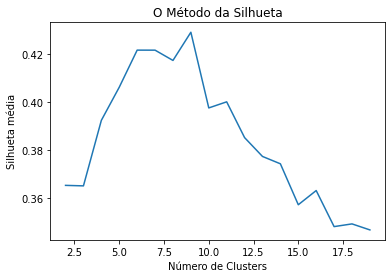

In [ ]:
sill = []

for i in range(2, 20):
    kmeans = KMeans(n_clusters = i, random_state=0)
    kmeans.fit(temp)
    cluster_labels = kmeans.predict(temp)

    sill.append(silhouette_score(temp, cluster_labels))
    
plt.plot(range(2, 20), sill)
plt.title('O Método da Silhueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhueta média') 
plt.show()

É possível ver que o número de Clusters que maximiza a silhueta média é de 9 clusters, **MAS** perceba que o valor da silhueta média não difere significantemente de quando temos 6 clusters. Como sempre tentamos optar pelo modelo mais simples e que traga uma boa representação da realidade, vamos optar por ficar com 6 clusters ao invés de 9, mesmo que $K=6$ não maximize a silhueta média em nossos dados - veja que o resultado é muito parecido e que não valeria a pena tornar o modelo ainda mais complexo. Veja que esse é um julgamento muito subjetivo e só reforça a ideia de que quem decide no final do dia número de clusters é o cientista de dados e não o computador - é importante também descrever cada um dos clusters formados, checando se o resultado faz algum sentido teórico. Descrever os clusters e tentar contar uma história com base nos dados também deve te ajudar a escolher o número de clusters que serão formados. Preste atenção que quando estamos trabalhando com aprendizado não-supervisionado, a avaliação do modelo é um pouco mais complicada e menos objetiva. Vamos então formar 6 clusters:

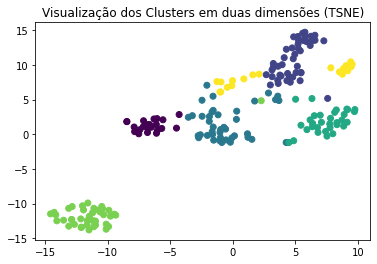

In [ ]:
n_clust = 6

kmeans = KMeans(n_clusters = n_clust, random_state=0)
kmeans.fit(temp)

plt.scatter(tsne[:,0], tsne[:,1], c = kmeans.labels_)
plt.title('Visualização dos Clusters em duas dimensões (TSNE)')

plt.show()

Dentre os 6 clusters formados, quais os mais coesos?

Vamos calcular a silhueta média para cada um dos grupos e diremos que aqueles que retornarem os maiores valores são os 'melhores clusters':

In [ ]:
silhouettes = silhouette_samples(temp, kmeans.labels_)

for k in range(n_clust):
  print("Silhueta Média para Cluster {:}: {:.2f} +- {:.2f}".format(k, 
                                                                   np.mean(silhouettes[kmeans.labels_==k]),
                                                                   np.std(silhouettes[kmeans.labels_==k]/np.sum(kmeans.labels_==k)**.5)))

Silhueta Média para Cluster 0: 0.53 +- 0.03
Silhueta Média para Cluster 1: 0.48 +- 0.02
Silhueta Média para Cluster 2: 0.33 +- 0.03
Silhueta Média para Cluster 3: 0.32 +- 0.03
Silhueta Média para Cluster 4: 0.52 +- 0.02
Silhueta Média para Cluster 5: 0.32 +- 0.03


Agora nos resta descrever os clusters com base em suas características. Vamos aqui descrever dois dos clusters formados, o 0 e o 1:

In [ ]:
labels = pd.DataFrame(kmeans.predict(temp))
labels.columns = ['Cluster'] 

data=pd.merge(data,labels, left_index=True, right_index=True)

Descrevendo o Cluster 0:

In [ ]:
data[data.loc[:,"Cluster"]==0].describe()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.0
mean,23.090909,0.590909,25.272727,25.727273,79.363636,0.0
std,13.147185,0.503236,5.257030,7.566731,10.504174,0.0
min,2.000000,0.000000,18.000000,15.000000,61.000000,0.0
25%,12.500000,0.000000,21.250000,19.250000,73.000000,0.0
50%,23.000000,1.000000,23.500000,24.500000,77.000000,0.0
75%,33.500000,1.000000,29.750000,32.250000,85.750000,0.0
max,46.000000,1.000000,35.000000,39.000000,99.000000,0.0


Descrevendo o Cluster 1:


In [ ]:
data[data.loc[:,"Cluster"]==1].describe()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.0
mean,83.777778,0.577778,56.333333,54.266667,49.066667,1.0
std,24.911561,0.499495,8.453079,8.975725,6.300794,0.0
min,41.000000,0.000000,43.000000,38.000000,35.000000,1.0
25%,64.000000,0.000000,49.000000,47.000000,45.000000,1.0
50%,81.000000,1.000000,54.000000,54.000000,49.000000,1.0
75%,103.000000,1.000000,65.000000,62.000000,55.000000,1.0
max,161.000000,1.000000,70.000000,79.000000,60.000000,1.0


### Exercício 1: quais são as maiores diferenças entre os dois clusters acima? Tente olhar não só para a média.

### Exercício 2: crie uma persona para cada um dos clusters.